# Using r-obistools and r-obis to explore the OBIS database


The [Ocean Biogeographic Information System (OBIS)](http://www.iobis.org) is an open-access data and information system for marine biodiversity for science, conservation and sustainable development.

In this example we will use R libraries [`obistools`](https://iobis.github.io/obistools) and [`robis`](https://iobis.github.io/robis) to search data regarding marine turtles occurrence in the South Atlantic Ocean.

Let's start by loading the R-to-Python extension and check the database for the 7 known species of marine turtles found in the world's oceans.

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R -o matches

library(obistools)


species <- c(
    'Caretta caretta',
    'Chelonia mydas',
    'Dermochelys coriacea',
    'Eretmochelys imbricata',
    'Lepidochelys kempii',
    'Lepidochelys olivacea',
    'Natator depressa'
)

matches = match_taxa(species, ask=FALSE)

R[write to console]: 7 names, 0 without matches, 0 with multiple matches



In [3]:
matches

scientificName                           scientificNameID  \
1         Caretta caretta  urn:lsid:marinespecies.org:taxname:137205   
2          Chelonia mydas  urn:lsid:marinespecies.org:taxname:137206   
3    Dermochelys coriacea  urn:lsid:marinespecies.org:taxname:137209   
4  Eretmochelys imbricata  urn:lsid:marinespecies.org:taxname:137207   
5     Lepidochelys kempii  urn:lsid:marinespecies.org:taxname:137208   
6   Lepidochelys olivacea  urn:lsid:marinespecies.org:taxname:220293   
7        Natator depressa  urn:lsid:marinespecies.org:taxname:344093   

  match_type  
1      exact  
2      exact  
3      exact  
4      exact  
5      exact  
6      exact  
7      exact

We got a nice DataFrame back with records for all 7 species of turtles and their corresponding `ID` in the database.

Now let us try to obtain the occurrence data for the South Atlantic. We will need a vector geometry for the ocean basin in the [well-known test (WKT)](https://en.wikipedia.org/wiki/Well-known_text) format to feed into the `robis` `occurrence` function.

In this example we converted a South Atlantic shapefile to WKT with geopandas, but one can also obtain geometries by simply drawing them on a map with [iobis maptool](http://iobis.org/maptool).

In [4]:
import geopandas

gdf = geopandas.read_file("data/oceans.shp")

sa = gdf.loc[gdf["Oceans"] == "South Atlantic Ocean"]["geometry"].loc[0]

atlantic = sa.to_wkt()

In [5]:
%%R -o turtles -i atlantic
library(robis)


turtles = occurrence(
    species,
    geometry=atlantic,
)

names(turtles)

Retrieved 5000 records of approximately 5525 (90%)
Retrieved 5525 records of approximately 5525 (100%)


  [1] "date_year"                     "scientificNameID"             
  [3] "scientificName"                "dynamicProperties"            
  [5] "superfamilyid"                 "individualCount"              
  [7] "associatedReferences"          "dropped"                      
  [9] "aphiaID"                       "decimalLatitude"              
 [11] "type"                          "taxonRemarks"                 
 [13] "phylumid"                      "familyid"                     
 [15] "catalogNumber"                 "occurrenceStatus"             
 [17] "basisOfRecord"                 "superclass"                   
 [19] "modified"                      "maximumDepthInMeters"         
 [21] "id"                            "order"                        
 [23] "recordNumber"                  "georeferencedDate"            
 [25] "superclassid"                  "verbatimEventDate"            
 [27] "dataset_id"                    "decimalLongitude"             
 [29] "collectionCod

In [6]:
set(turtles["scientificName"])

{'Caretta caretta',
 'Chelonia mydas',
 'Dermochelys coriacea',
 'Eretmochelys imbricata',
 'Lepidochelys kempii',
 'Lepidochelys olivacea'}

Note that there are no occurrences for *Natator depressa* (Flatback sea turtle) in the South Atlantic.
The Flatback sea turtle can only be found in the waters around the Australian continental shelf.


With `ggplot2` we can quickly put together a of occurrences over time.

R[write to console]: Learn more about the underlying theory at https://ggplot2-book.org/



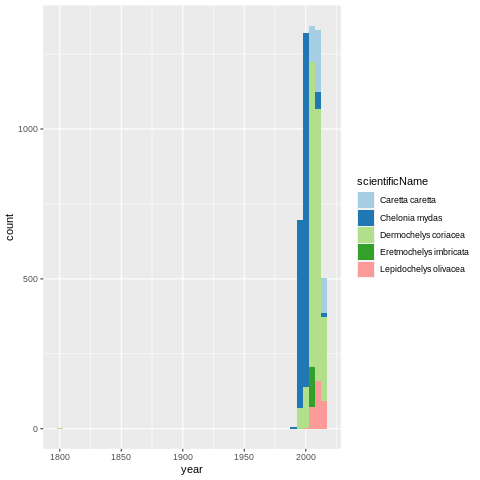

In [7]:
%%R

turtles$year <- as.numeric(format(as.Date(turtles$eventDate), "%Y"))
table(turtles$year)

library(ggplot2)

ggplot() +
 geom_histogram(
     data=turtles,
     aes(x=year, fill=scientificName),
     binwidth=5) +
 scale_fill_brewer(palette='Paired')

One would guess that the 2010 count increase would be due to an increase in the sampling effort, but the drop around 2010 seems troublesome. It can be a real threat to these species, or the observation efforts were defunded.


To explore this dataset further we can make use of the `obistools`' R package. `obistools` has many visualization and quality control routines built-in. Here is an example on how to use `plot_map` to quickly visualize the data on a geographic context.

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




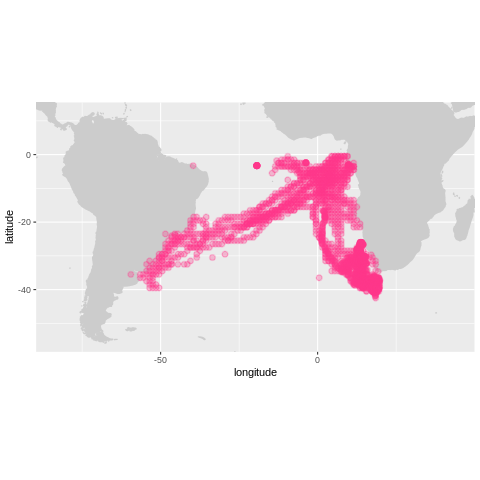

In [8]:
%%R

library(dplyr)

coriacea <- turtles %>% filter(species=='Dermochelys coriacea')
plot_map(coriacea, zoom=TRUE)

However, if we want to create a slightly more elaborate map with clusters and informative pop-ups, can use the python library `folium`.instead.

In [9]:
import folium
from pandas import DataFrame


def filter_df(df):
    return df[["institutionCode", "individualCount", "sex", "eventDate"]]


def make_popup(row):
    classes = "table table-striped table-hover table-condensed table-responsive"
    html = DataFrame(row).to_html(classes=classes)
    return folium.Popup(html)


def make_marker(row, popup=None):
    location = row["decimalLatitude"], row["decimalLongitude"]
    return folium.Marker(location=location, popup=popup)

In [10]:
from folium.plugins import MarkerCluster

species_found = sorted(set(turtles["scientificName"]))

clusters = {s: MarkerCluster() for s in species_found}
groups = {s: folium.FeatureGroup(name=s) for s in species_found}

In [11]:
turtles

date_year                           scientificNameID  \
1           2015  urn:lsid:marinespecies.org:taxname:220293   
2           2014  urn:lsid:marinespecies.org:taxname:137205   
3           2012  urn:lsid:marinespecies.org:taxname:137209   
4           2003  urn:lsid:marinespecies.org:taxname:137209   
5           2012  urn:lsid:marinespecies.org:taxname:137209   
...          ...                                        ...   
5521        2003  urn:lsid:marinespecies.org:taxname:137209   
5522 -2147483648  urn:lsid:marinespecies.org:taxname:137208   
5523        1997  urn:lsid:marinespecies.org:taxname:137206   
5524        1997  urn:lsid:marinespecies.org:taxname:137206   
5525        1998  urn:lsid:marinespecies.org:taxname:137206   

             scientificName   dynamicProperties  superfamilyid  \
1     Lepidochelys olivacea  MachineObservation         987094   
2           Caretta caretta  MachineObservation         987094   
3      Dermochelys coriacea  MachineObservation         987094   
4      Dermochelys coriacea                None         987094   
5      Dermochelys coriacea                None         987094   
...                     ...                 ...            ...   
5521   Dermochelys coriacea                None         987094   
5522    Lepidochelys kempii                None         987094   
5523         Chelonia mydas                None         987094   
5524         Chelonia mydas                None         987094   
5525         Chelonia mydas                None         987094   

     individualCount                               associatedReferences  \
1                  1  [{"crossref":{"citeinfo":{"origin":"Coyne, M. ...   
2                  1  [{"crossref":{"citeinfo":{"origin":"Coyne, M. ...   
3                  1  [{"crossref":{"citeinfo":{"origin":"Robinson, ...   
4                  1  [{"crossref":{"citeinfo":{"origin":"Luschi, P....   
5                  1  [{"crossref":{"citeinfo":{"origin":"Robinson, ...   
...              ...                                                ...   
5521               1  [{"crossref":{"citeinfo":{"origin":"Luschi, P....   
5522            None                                               None   
5523               1  [{"crossref":{"citeinfo":{"origin":"Luschi, P....   
5524               1  [{"crossref":{"citeinfo":{"origin":"Luschi, P....   
5525               1  [{"crossref":{"citeinfo":{"origin":"Luschi, P....   

      dropped  aphiaID  decimalLatitude  ... preparations identifiedBy  \
1           0   220293        -6.500000  ...         None         None   
2           0   137205       -35.500000  ...         None         None   
3           0   137209       -33.500000  ...         None         None   
4           0   137209       -26.864000  ...         None         None   
5           0   137209       -25.466100  ...         None         None   
...       ...      ...              ...  ...          ...          ...   
5521        0   137209       -30.100000  ...         None         None   
5522        0   137208        -0.700139  ...         None         None   
5523        0   137206        -8.705000  ...         None         None   
5524        0   137206        -8.716000  ...         None         None   
5525        0   137206        -9.352000  ...         None         None   

      typeStatus  otherCatalogNumbers locationID language eventID  \
1           None                 None       None     None    None   
2           None                 None       None     None    None   
3           None                 None       None     None    None   
4           None                 None       None     None    None   
5           None                 None       None     None    None   
...          ...                  ...        ...      ...     ...   
5521        None                 None       None     None    None   
5522        None                 None       None     None    None   
5523        None                 None       No

In [12]:
m = folium.Map()

for turtle in species_found:
    df = turtles.loc[turtles["scientificName"] == turtle]
    for k, row in df.iterrows():
        popup = make_popup(filter_df(row))
        make_marker(row, popup=popup).add_to(clusters[turtle])
    clusters[turtle].add_to(groups[turtle])
    groups[turtle].add_to(m)


m.fit_bounds(m.get_bounds())
folium.LayerControl().add_to(m);

In [13]:
def embed_map(m):
    from IPython.display import HTML

    m.save("index.html")
    with open("index.html") as f:
        html = f.read()

    iframe = '<iframe srcdoc="{srcdoc}" style="width: 100%; height: 750px; border: none"></iframe>'
    srcdoc = html.replace('"', "&quot;")
    return HTML(iframe.format(srcdoc=srcdoc))


embed_map(m)

/home/filipe/miniconda3/envs/IOOS/lib/python3.9/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


We can get fancy and use shapely to "merge" the points that are on the ocean and get an idea of migrations routes.

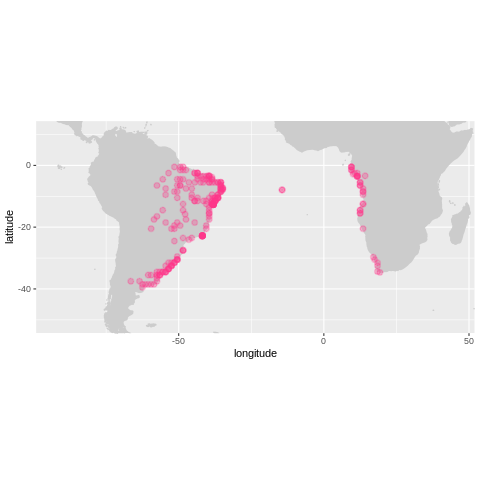

In [13]:
%%R -o land

land <- check_onland(turtles)

plot_map(land, zoom=TRUE)

First let's remove the entries that are on land.

In [14]:
turtles.set_index("id", inplace=True)
land.set_index("id", inplace=True)
mask = turtles.index.isin(land.index)
ocean = turtles[~mask]

Now we can use shapely's buffer to "connect" the points that are close to each other to visualize a possible migration path.

In [15]:
from palettable.cartocolors.qualitative import Bold_6
from shapely.geometry import MultiPoint

colors = {s: c for s, c in zip(species_found, Bold_6.hex_colors)}
style_function = lambda color: (
    lambda feature: dict(color=color, weight=2, opacity=0.6)
)

m = folium.Map()

for turtle in species_found:
    df = ocean.loc[ocean["scientificName"] == turtle]
    positions = MultiPoint(
        list(zip(df["decimalLongitude"].values, df["decimalLatitude"].values))
    ).buffer(distance=2)
    folium.GeoJson(
        positions.__geo_interface__,
        name=turtle,
        tooltip=turtle,
        style_function=style_function(color=colors[turtle]),
    ).add_to(m)

m.fit_bounds(m.get_bounds())
folium.LayerControl().add_to(m)

m

One interesting feature of this map is *Dermochelys coriacea*'s migration between Brazilian and African shores.

More information on [*Dermochelys coriacea*](http://www.iucnredlist.org/details/6494/0) and the other Sea Turtles can be found in the species [IUCN red list](http://www.iucnredlist.org).